In [30]:
import pandas as pd
import numpy as np

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from pandas.core.dtypes.common import is_string_dtype
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import forest, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,KFold, cross_val_score
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.feature_extraction.text import CountVectorizer

import xgboost as xgb
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from geopy import geocoders

### Read train and test data

In [234]:
data = pd.read_csv("train-parking.csv", parse_dates={"datetime" : ["Date", "Time"]})
test = pd.read_csv("test-no-labels-with-id.csv", parse_dates={"datetime" : ["Date", "Time"]})

In [10]:
data.head()

,datetime,Street,From,To,Real.Spots,Street.Length,any_spot
0,2014-01-07 16:19:00,Mission Street,25th Street,26th Street,4,179.132970,1
1,2014-01-18 20:42:00,Polk Street,Ellis Street,Olive Street,0,52.740210,0
2,2014-01-18 20:39:00,Van Ness Avenue,Geary Boulevard,Myrtle Street,0,52.517840,0
3,2014-01-18 20:38:00,Van Ness Avenue,Bush Street,Fern Street,0,52.405315,0
4,2014-01-18 20:38:00,Van Ness Avenue,Daniel Burnham Court,Post Street,0,52.191193,0


In [9]:
data.columns

Index(['datetime', 'Street', 'From', 'To', 'Real.Spots', 'Street.Length',
       'any_spot'],
      dtype='object')

In [608]:
test.columns

Index(['datetime', 'id', 'Street', 'From', 'To', 'Street.Length'], dtype='object')

In [603]:
data.shape, test.shape

((1100, 7), (726, 6))

In [616]:
data.datetime.min(), data.datetime.max()

(Timestamp('2014-01-07 16:19:00'), Timestamp('2014-03-28 22:03:00'))

In [617]:
test.datetime.min(), test.datetime.max() # there is one day of overlapping between data and test

(Timestamp('2014-03-28 16:25:00'), Timestamp('2016-11-04 21:56:00'))

### Read weather data

In [507]:
# http://w2.weather.gov/climate/xmacis.php?wfo=mtr
weather = pd.read_csv("weather.csv", parse_dates={"date" : ['Date']})
weather = weather.drop(['HDD', 'CDD'], axis=1)

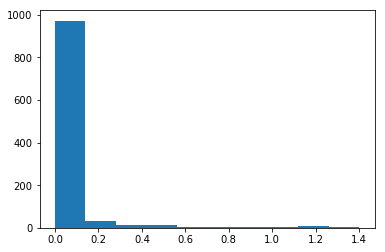

In [1534]:
plt.hist(weather.Precipitation.values, range=(0, 1.4)) #, bins = np.arange(0, 1.4, 0.1)
plt.show()

In [400]:
weather.head()

,date,Temperature_Max,Temperature_Min,Temperature_Avg,Temperature_Departure,Precipitation
0,2014-01-01,63,44,53.5,2.9,0.0
1,2014-01-02,63,48,55.5,4.9,0.0
2,2014-01-03,64,49,56.5,5.9,0.0
3,2014-01-04,66,46,56.0,5.4,0.0
4,2014-01-05,66,48,57.0,6.4,0.0


### Read cleaned Parking record

In [435]:
import feather
df = feather.read_dataframe('meterdata_with_datetime.feather')
df.head()

,index,lat,lon,datetime,street_block,convtd,hour,minute,day,month,year
0,37,37.781675,-122.401493,1473620708000,Mission Street_11th Street_Mission Street,2016-09-11 19:05:08.000,19,5,11,9,2016
1,69,37.772285,-122.416183,1471976196128,Mission Street_11th Street_Mission Street,2016-08-23 18:16:36.128,18,16,23,8,2016
2,70,37.777534,-122.405716,1471985902600,Mission Street_11th Street_Mission Street,2016-08-23 20:58:22.600,20,58,23,8,2016
3,72,37.783095,-122.405746,1472576226100,Mission Street_11th Street_Mission Street,2016-08-30 16:57:06.100,16,57,30,8,2016
4,77,37.781800,-122.401840,1473630754600,Mission Street_11th Street_Mission Street,2016-09-11 21:52:34.600,21,52,11,9,2016


In [58]:
df.convtd.min(), df.convtd.max()

(Timestamp('2015-03-10 01:23:35'), Timestamp('2017-09-20 04:24:23'))

In [436]:
temp = df.groupby('street_block')['street_block'].count()
parking_count = pd.DataFrame({'Block': np.array(temp.keys()), 'parkings_by_block': temp.values}).set_index('Block') 
parking_count.head()

,parkings_by_block
Block,
23rd Street_Bartlett Street_Valencia Street,946
23rd Street_Mission Street_Bartlett Street,2247
23rd Street_Mission Street_Capp Street,2241
23rd Street_South Van Ness Avenue_Capp Street,1097
Battery Street_California Street_Pine Street,636


### Read cleaned sensor data

In [404]:
df1 = pd.read_feather('new_sensor_data2') 
# df2 = pd.read_feather('street_seg_id')
df1.head(10)

,Street_Block,Available_Spots,Dayofweek,month,hour,year,lat,lng,street_id,count
0,Kearny Street_2,1.0,6,7,16,2012,37.790518,-122.404027,27,1
1,Kearny Street_2,4.0,6,7,20,2012,37.790518,-122.404027,27,1
2,Kearny Street_2,5.0,6,7,5,2012,37.790518,-122.404027,27,1
3,Kearny Street_2,4.0,6,7,21,2012,37.790518,-122.404027,27,1
4,Kearny Street_2,5.0,1,7,6,2012,37.790518,-122.404027,27,1
5,Kearny Street_2,1.0,6,7,12,2012,37.790518,-122.404027,27,1
6,Kearny Street_2,5.0,6,7,4,2012,37.790518,-122.404027,27,1
7,Kearny Street_2,5.0,6,7,22,2012,37.790518,-122.404027,27,1
8,Kearny Street_2,4.0,6,7,1,2012,37.790518,-122.404027,27,1
9,Kearny Street_2,6.0,1,10,7,2012,37.790518,-122.404027,27,1


In [405]:
temp = df1[df1.year==2012].groupby("month").Available_Spots.sum()
monthly_adj =pd.DataFrame({'month': np.arange(1,13), 'parking_by_month': temp.values}).set_index('month') 
monthly_adj

,parking_by_month
month,
1,58192.0
2,53227.0
3,55267.0
4,52951.0
5,58193.0
6,55635.0
7,61736.0
8,62037.0
9,60509.0


### Preprocessing
- Add datetime information such as DOW, hour, month
- Concatenate street-from-to to be block column
- Correct street length
- Label encoding on block
- join external data

In [670]:
data = pd.read_csv("train-parking.csv", parse_dates={"datetime" : ["Date", "Time"]})

In [671]:
data["DOW"] = data['datetime'].dt.dayofweek
data["hour"] = data['datetime'].dt.hour #7-19
data["month"] = data['datetime'].dt.month
data["date"] = data['datetime'].dt.date 
data['minute'] = data['datetime'].dt.minute
data["date"] = pd.to_datetime(data.date)

In [638]:
# NOT RUN
cal = calendar()
holidays = cal.holidays(start=data.datetime.min(), end=test.datetime.max())
holidays = holidays.append(holidays-timedelta(days=1))

data['Holiday'] = data['datetime'].isin(holidays)
# there is no record on holiday in training data

In [672]:
data['Block'] = data["Street"]+ "_" + data['From']+ "_" + data['To']

In [673]:
# Incase the street length was wrong for any street, we take a median for street length for each street
street_median_length =data.groupby("Street")["Street.Length"].median()
data = data.join(street_median_length, on="Street", rsuffix='_correct')

In [674]:
# label encoding block by their any_spot rankings
le = LabelEncoder()
le.fit(data.Block)

LabelEncoder()

In [675]:
data['Block_num'] = le.transform(data.Block) 

In [676]:
# join external data
# parking records
data = data.join(parking_count, on="Block", how="left")
data["parkings_by_block"].fillna(-1, inplace=True) 
data = data.join(parking_count_by_hour, on="hour", how="left")

# sensor - month
data = data.join(monthly_adj, on="month", how="left")

# weather
data = data.merge(weather, how='left')

In [973]:
data.head()

,datetime,Street,From,To,Real.Spots,Street.Length,any_spot,DOW,hour,month,...,Temperature_Departure,Precipitation,hour_more_parking,DOW_ranking,Block_more_parking,Block_less_parking,Block_any_spotmean_enc,DOW_Real.Spotsmean_enc,hour_Real.Spotsmean_enc,Block_fre
0,2014-01-07 16:19:00,Mission Street,25th Street,26th Street,4,179.132970,1,1,16,1,...,4.3,0.0,True,3,True,False,0.444444,0.276923,1.323944,20
1,2014-01-18 20:42:00,Polk Street,Ellis Street,Olive Street,0,52.740210,0,5,20,1,...,7.7,0.0,False,5,False,True,0.125000,1.792969,0.949367,10
2,2014-01-18 20:39:00,Van Ness Avenue,Geary Boulevard,Myrtle Street,0,52.517840,0,5,20,1,...,7.7,0.0,False,5,False,True,0.200000,1.792969,0.949367,14
3,2014-01-18 20:38:00,Van Ness Avenue,Bush Street,Fern Street,0,52.405315,0,5,20,1,...,7.7,0.0,False,5,False,False,0.272727,1.792969,0.949367,14
4,2014-01-18 20:38:00,Van Ness Avenue,Daniel Burnham Court,Post Street,0,52.191193,0,5,20,1,...,7.7,0.0,False,5,False,True,0.153846,1.792969,0.949367,16


### Split train, val sets, and create features on train

In [678]:
## to be deleted
def split_based_hour(data, train_per):
    """ Split data based on column hour.
    
    Use 20% of the date for validation.
    Inputs:
       data: dataframe from avazu
    Returns:
       train:
       val: 20% of the largest values of column "hour".
    """
    N = int(train_per*len(data))
    data = data.sort_values(by="datetime")
    train = data[:N].copy()
    val = data[N:].copy()
    return train.reset_index(), val.reset_index()

train, val = split_based_hour(data, 0.8)

In [377]:
len(train), len(val)

(880, 220)

### New features based on train
If the new features created based on train work well with validation set, then we are comfortable doing the same on whole data and predict for test set.
1. Identify busy street/hour/dow

In [666]:
train.groupby("hour")["any_spot"].mean()

hour
7     0.360656
8     0.361111
9     0.482759
10    0.200000
11    0.225806
12    0.227273
13    0.368421
14    0.454545
15    0.558140
16    0.465517
17    0.441860
18    0.327273
19    0.375000
20    0.250000
21    0.437500
Name: any_spot, dtype: float64

In [679]:
temp = train.groupby("hour")["any_spot"].mean()
train['hour_more_parking'] = train['hour'].isin(temp[temp>0.4].keys())

val['hour_more_parking'] = val['hour'].isin(temp[temp>0.4].keys())

In [1189]:
train.groupby("DOW")["any_spot"].mean()

DOW
0    0.385475
1    0.375000
2    0.338462
3    0.378378
4    0.426829
5    0.323529
6    0.494382
Name: any_spot, dtype: float64

In [680]:
temp = train.groupby("DOW")["any_spot"].mean().sort_values(ascending=True)
DOW_rank = pd.DataFrame({'DOW': temp.reset_index(drop=False).DOW.values, 'DOW_ranking':range(7)}).set_index('DOW') 

train = train.join(DOW_rank, on="DOW", rsuffix='_ranking')
val = val.join(DOW_rank, on="DOW", rsuffix='_ranking')

In [681]:
temp = train.groupby("Block")["any_spot"].mean()
train['Block_more_parking'] = train["Block"].isin(temp[temp>0.55].keys())
train['Block_less_parking'] = train["Block"].isin(temp[temp<0.2].keys())

val['Block_more_parking'] = val["Block"].isin(temp[temp>0.55].keys())
val['Block_less_parking'] = val["Block"].isin(temp[temp<0.2].keys())

### Mean encoding

In [122]:
def reg_target_encoding(train, col, target, splits=5):
    """ Computes regularize mean encoding.
    Inputs:
       train: training dataframe
       
    """
    ### mean_encoding
    kf = KFold(n_splits=splits, shuffle=False)
    new_col = col + "_" + target +  "mean_enc"
    train[new_col] = np.nan
    global_mean = train[target].mean()

    for tr_ind, val_ind in kf.split(train):
        X_tr, X_val = train.iloc[tr_ind], train.iloc[val_ind]
        mean_enc = X_tr.groupby(col)[target].mean()
        train.loc[val_ind, new_col] = X_val[col].map(mean_enc)

    train[new_col].fillna(global_mean, inplace=True) 

In [682]:
# reg_target_encoding(train,'Block',"Real.Spots")  # tbd
reg_target_encoding(train,'Block',"any_spot") 
reg_target_encoding(train,'DOW',"Real.Spots") 
reg_target_encoding(train,'hour',"Real.Spots") 
# reg_target_encoding(train,'DOW',"any_spot")   #tbd
# reg_target_encoding(train,'hour',"any_spot")  # tbd

### Calculate frequency

In [683]:
street_freq = train.groupby("Block")['Block'].count()
train = train.join(street_freq, on="Block", rsuffix='_fre')

In [686]:
train.shape

(880, 33)

### Transforming validation set

In [125]:
def mean_encoding_test(test, train, col, target):
    """ Computes target enconding for test data.
    
    This is similar to how we do validation
    """
    ### BEGIN SOLUTION
    mean_enc = train.groupby(col)[target].mean()
    global_mean = train[target].mean()
    new_col = col + "_" + target + "mean_enc"
    test[new_col] = np.nan
    test[new_col] = test[col].map(mean_enc)
    test[new_col].fillna(global_mean, inplace=True)

In [687]:
mean_encoding_test(val, train,'Block',"any_spot" ) 
# mean_encoding_test(val, train,'DOW',"any_spot" )  # tbd
#mean_encoding_test(val, train,'hour',"any_spot" ) # tbd

# mean_encoding_test(val, train,'Block',"Real.Spots" ) # tbd
mean_encoding_test(val, train,'DOW',"Real.Spots" ) 
mean_encoding_test(val, train,'hour',"Real.Spots" ) 

In [688]:
val = val.join(street_freq, on="Block", rsuffix='_fre')

In [689]:
val.shape

(220, 33)

### Final touch before modeling

In [665]:
## Handy function

# check for infinit values in a column
# np.all(np.isfinite(train['Holiday']))
# check for NA
val.isnull().values.sum() 
#X_valid[X_valid.isnull().values]

0

In [822]:
y_train = train['any_spot'].values
X_train = train.drop(['Temperature_Departure','Temperature_Avg','year','parkings_by_hour','index','date','any_spot','Real.Spots','datetime','month','DOW','Street','From','To','Block','Street.Length'], axis=1)

new_val = val.dropna()
y_valid = new_val['any_spot'].values
X_valid = new_val.drop(['Temperature_Departure','Temperature_Avg','year','parkings_by_hour','index','date','any_spot','Real.Spots','datetime','month','DOW','Street','From','To','Block','Street.Length'], axis=1)

In [468]:
X_train.dtypes

hour                         int64
year                         int64
minute                       int64
Street.Length_correct      float64
Block_num                    int64
parkings_by_block          float64
parkings_by_hour             int64
parkings_by_minute           int64
parking_by_month           float64
Temperature_Max              int64
Temperature_Min              int64
Precipitation              float64
hour_more_parking             bool
DOW_ranking                  int64
Block_more_parking            bool
Block_less_parking            bool
Block_any_spotmean_enc     float64
DOW_Real.Spotsmean_enc     float64
hour_Real.Spotsmean_enc    float64
Block_fre                    int64
dtype: object

In [130]:
def f_05(y, pred):
    
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    
    p = tp/(tp+fp)
    r = tp/(tp+fn)

    return 1.25*p*r/(0.25*p + r)
scorer = make_scorer(f_05, greater_is_better=True)

### Prepare test set

In [696]:
test = pd.read_csv("test-no-labels-with-id.csv", parse_dates={"datetime" : ["Date", "Time"]})

In [697]:
test["DOW"] = test['datetime'].dt.dayofweek
test["hour"] = test['datetime'].dt.hour #7-19
test["month"] = test['datetime'].dt.month
test["date"] = test['datetime'].dt.date  
test["minute"] = test['datetime'].dt.minute 
test["date"] = pd.to_datetime(test.date)

test['Block'] = test["Street"]+ "_" + test['From']+ "_" + test['To']
test = test.join(street_median_length, on="Street", rsuffix='_correct')
test['Block_num'] = le.transform(test.Block) 

# join external data
test = test.join(parking_count, on="Block", how="left")
test["parkings_by_block"].fillna(-1, inplace=True) 
test = test.join(parking_count_by_hour, on="hour", how="left")

test = test.join(monthly_adj, on="month", how="left")
test = test.merge(weather, how='left')

In [698]:
temp = data.groupby("hour")["any_spot"].mean()
data['hour_more_parking'] = data['hour'].isin(temp[temp>0.4].keys())
test['hour_more_parking'] = test['hour'].isin(temp[temp>0.4].keys())

temp = data.groupby("DOW")["any_spot"].mean().sort_values(ascending=True)
DOW_rank = pd.DataFrame({'DOW': temp.reset_index(drop=False).DOW.values, 'DOW_ranking':range(7)}).set_index('DOW') 
data = data.join(DOW_rank, on="DOW", rsuffix='_ranking')
test = test.join(DOW_rank, on="DOW", rsuffix='_ranking')

temp = data.groupby("Block")["any_spot"].mean()
data['Block_more_parking'] = data["Block"].isin(temp[temp>0.55].keys())
data['Block_less_parking'] = data["Block"].isin(temp[temp<0.2].keys())

test['Block_more_parking'] = test["Block"].isin(temp[temp>0.55].keys())
test['Block_less_parking'] = test["Block"].isin(temp[temp<0.2].keys())

In [699]:
reg_target_encoding(data,'Block',"any_spot") 
reg_target_encoding(data,'DOW',"Real.Spots") 
reg_target_encoding(data,'hour',"Real.Spots") 
# reg_target_encoding(data,'Street',"any_spot" )  

street_freq = data.groupby("Block")['Block'].count()
data = data.join(street_freq, on="Block", rsuffix='_fre')

mean_encoding_test(test, data,'Block',"any_spot" ) 
# mean_encoding_test(test, data,'Street',"any_spot" ) 
mean_encoding_test(test, data,'DOW',"Real.Spots" ) 
mean_encoding_test(test, data,'hour',"Real.Spots" ) 

test = test.join(street_freq, on="Block", rsuffix='_fre')

In [880]:
y_data = data['any_spot'].values
X_data = data.drop([ 'Temperature_Departure', 'Temperature_Avg','date','any_spot','Real.Spots','datetime','month','DOW','Street','From','To','Block','Street.Length'], axis=1)

id_ = test['id'] # 
X_test = test.drop(['id','Temperature_Departure','Temperature_Avg','date','datetime','month','DOW','Street','From','To','Block','Street.Length'], axis=1)

In [829]:
rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [10,15, 20,25, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_features': [0.6, 0.7, 0.8, 0.9],
    #'min_samples_split':[.23,.24,.25,.26,.27,0.28],
    'min_samples_leaf':[15, 20, 25, 30]
    #'max_depth':[2,4, 5]
    }
grid_search = GridSearchCV(rf, param_grid=param_grid, scorer = scorer)
grid_search.fit(X_data, y_data)
grid_search.best_params_

{'max_features': 0.7, 'min_samples_leaf': 30, 'n_estimators': 15}

In [855]:
m = RandomForestClassifier(n_estimators=15, min_samples_leaf=30,max_features=0.7, n_jobs=8)
m.fit(X_data, y_data)
f_05(y_data, m.predict(X_data))

0.69889341875364008

In [ ]:
rf_pred = m.predict(X_test)

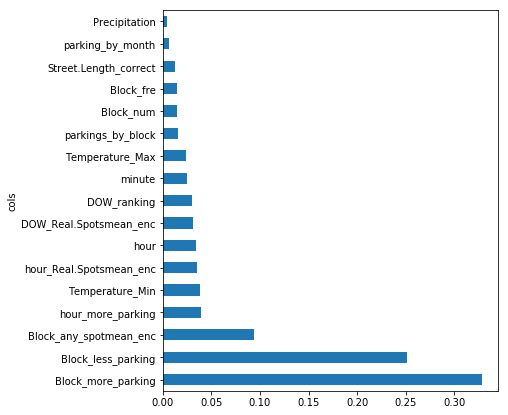

In [833]:
def plot_fi(fi): return fi.plot('cols', 'imp','barh', figsize=(6,7), legend=False)
fi = pd.DataFrame({'cols':X_data.columns, 'imp':m.feature_importances_}
                      ).sort_values('imp', ascending=False)

plot_fi(fi)
plt.show()

In [1]:
xgb = xgb.XGBClassifier()
param_grid = {
    'n_estimators': [200,250,300, 350],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.1, 0.01, 0.005, 0.001],
    }
grid_search = GridSearchCV(xgb, param_grid=param_grid, scorer = scorer)
grid_search.fit(X_data, y_data)
grid_search.best_params_

{'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.001}


In [904]:
import xgboost as xgb

gbm = xgb.XGBClassifier(max_depth=2, n_estimators=300, learning_rate=0.001).fit(X_data, y_data)
yhat = gbm.predict(X_data)
f_05(y_data, yhat) # 0.612 to real is 0.559 (2, 300, 0.001)

0.61243144424131624

In [ ]:
xgb_pred = gbm.predict(X_test)

Predictions made with both random forest and XGBoost from time to time during the inclass Kaggle competition was submitted 

### Stacking

In [921]:
pred1 = pd.read_csv("prob1.txt") 
pred2 = pd.read_csv("prob2.txt").set_index('id')
pred3 = pd.read_csv("prob3.txt").set_index('id')

In [922]:
# stacking predicted probabilities by mean
new_pred = pred1.join(pred2 , on='id', rsuffix='_2').join(pred3 , on='id', rsuffix='_3')
new_pred['pred']=new_pred[['any_spot','any_spot_2','any_spot_3']].mean(axis=1).astype(int)
new_pred = new_pred.drop(['any_spot','any_spot_3'], axis=1).rename(columns={'pred': 'any_spot'})

In [ ]:
# stacking hard predictions by vote
new_pred = pred1.join(pred3 , on='id', rsuffix='_3')
new_pred['pred']=new_pred[['any_spot','any_spot_3']].mean(axis=1)
mask = new_pred.pred > 0.5
new_pred.loc[mask, "pred"] = 1
mask = new_pred.pred <= 0.5
new_pred.loc[mask, "pred"] = 0

new_pred.pred = new_pred.pred.astype(int)
new_pred = new_pred.drop(['any_spot','any_spot_3'], axis=1).rename(columns={'pred': 'any_spot'})